In [ ]:
# All imports and setups in one block for simplicity
import os
from pathlib import Path
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Project paths
ROOT = Path(r"d:\Computer Science\UoL\Final Project\breast-cancer-detection")
MODEL_DIR = ROOT / "models"
DATA_DIR = ROOT / "data"
DATA_CSV_DIR = DATA_DIR / "csv"
DATA_JPEG_DIR = DATA_DIR / "kaggle/jpeg"
ckpt_path = MODEL_DIR / "best_model.h5"
artdir = ROOT / "artifacts"
figdir = ROOT / "figures"
figdir.mkdir(parents=True, exist_ok=True)
artdir.mkdir(parents=True, exist_ok=True)

# Checks
print("CSV dir exists:", DATA_CSV_DIR.exists())
print("JPEG dir exists:", DATA_JPEG_DIR.exists())
print("Model checkpoint path:", ckpt_path)

# A function to load and preprocess a single image
IMG_SIZE = (224, 224)
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE[0], IMG_SIZE[1]])
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

CSV dir exists: True
JPEG dir exists: True
Model checkpoint path: d:\Computer Science\UoL\Final Project\breast-cancer-detection\models\best_model.h5


Test predictions file found.

Analyzing a sample True Positive case: d:\Computer Science\UoL\Final Project\breast-cancer-detection\data\kaggle\jpeg\1.3.6.1.4.1.9590.100.1.2.114501333713829221314528651860576350917\1-069.jpg


d:\Computer Science\UoL\Final Project\breast-cancer-detection\venv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_471']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


Generating Grad-CAM visualization...


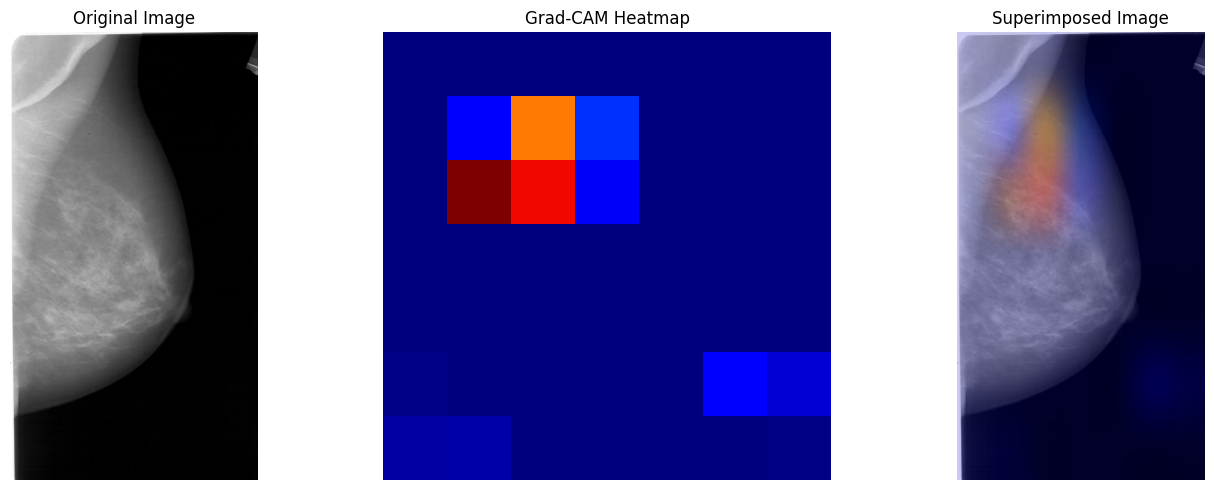

In [ ]:
# Define the model architecture and load weights
def get_model_architecture():
    """Builds and returns the MobileNetV2 model architecture."""
    IMG_SHAPE = (224, 224, 3)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs=base_model.input, outputs=outputs, name="MobileNetV2_breast_cancer")

# Build the model architecture
model = get_model_architecture()

# Load the weights from your HDF5 file
model.load_weights(str(ckpt_path))

# The last convolutional layer name for MobileNetV2
last_conv_layer_name = 'out_relu'
IMG_SIZE = (224, 224)

# Grad-CAM Helper Functions
def get_img_array(img_path, size):
    """Loads, resizes, and preprocesses a single image for the model."""
    img = tf.keras.utils.load_img(img_path, target_size=size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = mobilenet_preprocess(img_array)
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Computes a Grad-CAM heatmap from a preprocessed image and a trained model.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    Overlays the heatmap on the original image and saves the result.
    """
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range of 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use a jet colormap to make the heatmap visually appealing
    jet = plt.get_cmap("jet")
    jet_heatmap = jet(heatmap)[:, :, :3]  # Take only the RGB channels, not alpha

    # Resize the heatmap to the original image dimensions
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    # Display the three panels: original, heatmap, and superimposed
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(tf.keras.utils.array_to_img(img))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(superimposed_img)
    axes[2].set_title('Superimposed Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution block
try:
    # Load predictions CSV to get image paths
    test_predictions_df = pd.read_csv(artdir / "densenet121_test_predictions.csv")
    print("Test predictions file found.")
    
    # We will pick a specific image to visualize.
    # Let's find an image that was a True Positive (TP) - correctly predicted as malignant.
    # A True Positive has 'true' label = 1 and 'pred' label = 1.
    true_positives = test_predictions_df[(test_predictions_df['true'] == 1) & (test_predictions_df['pred'] == 1)]
    
    if not true_positives.empty:
        # Select the first one for our proof-of-concept
        img_path_to_explain = true_positives.iloc[2]['image_path']
        print(f"\nAnalyzing a sample True Positive case: {img_path_to_explain}")

        # Load and preprocess the image
        img_array = get_img_array(img_path_to_explain, size=IMG_SIZE)

        # Generate the heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        # Save and display the superimposed image
        print("Generating Grad-CAM visualization...")
        save_and_display_gradcam(img_path_to_explain, heatmap, cam_path=figdir / 'mobilenet_grad_cam_tp_poc__3.png')
    else:
        print("No True Positive cases found in the predictions file to analyze.")

except FileNotFoundError as e:
    print(f"Error: Required files not found. Please check your paths.")
    print(e)
    exit()

Test predictions file found.

Generating heatmaps for 8 sample images...


d:\Computer Science\UoL\Final Project\breast-cancer-detection\venv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_471']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


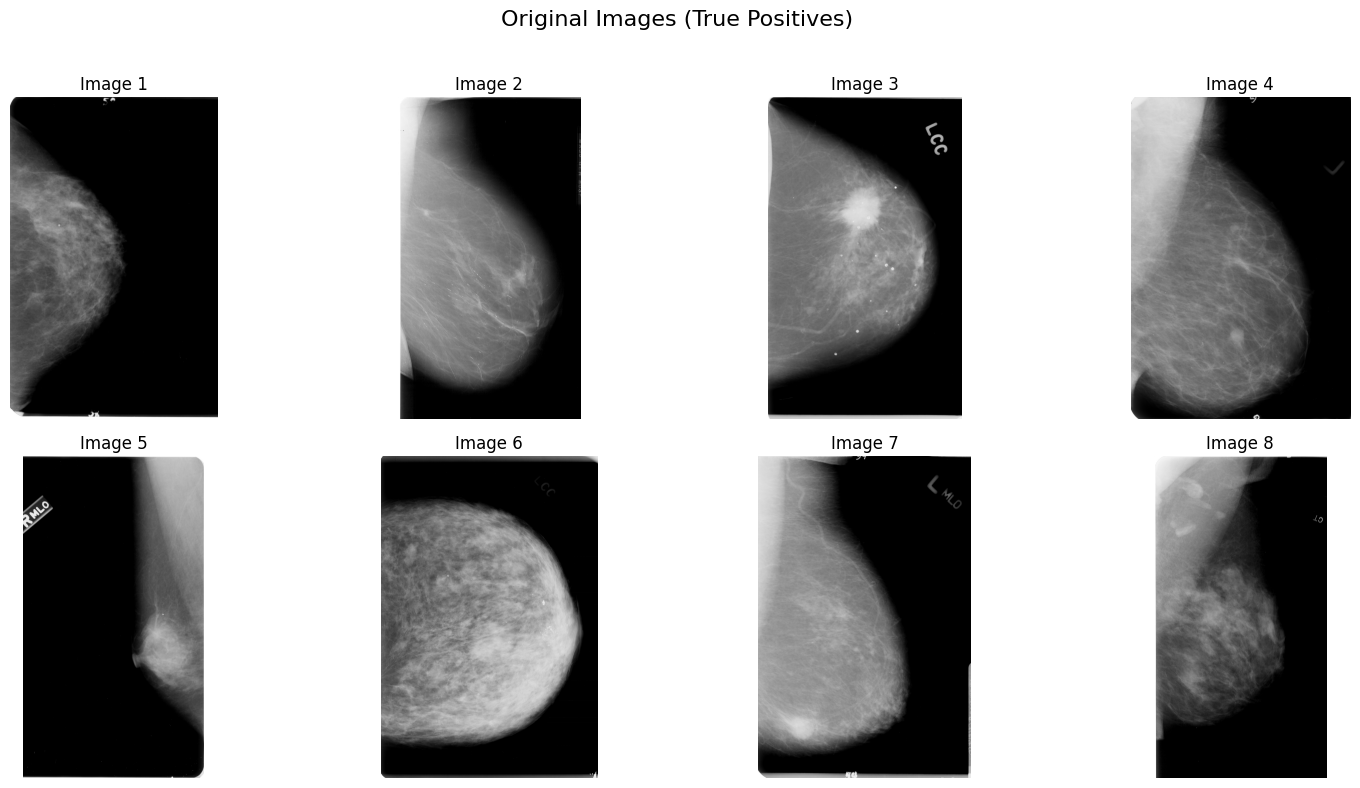

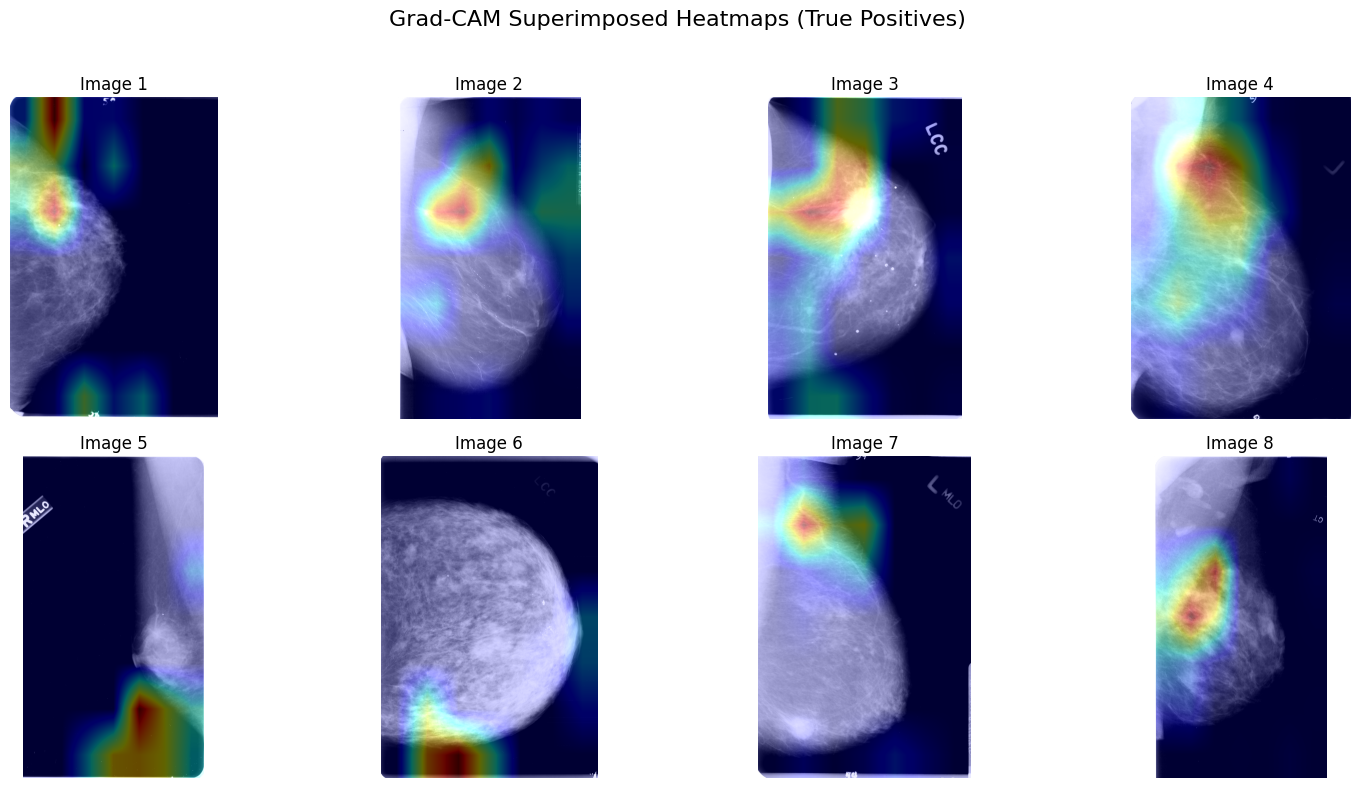


Image grids have been generated and saved.


In [ ]:
# Plotting a grid of Grad-CAM visualizations

# A new function to handle plotting a grid of images
def plot_image_grid(image_list, title, filename, cmap=None):
    """Plots a list of images in a 4x2 grid."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(image_list):
            ax.imshow(image_list[i], cmap=cmap)
            ax.set_title(f'Image {i+1}')
            ax.axis('off')
        else:
            ax.axis('off') # Hide unused subplots

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(figdir / filename, dpi=150)
    plt.show()

try:
    test_predictions_df = pd.read_csv(artdir / "densenet121_test_predictions.csv")
    print("Test predictions file found.")

    true_positives = test_predictions_df[(test_predictions_df['true'] == 1) & (test_predictions_df['pred'] == 1)]

    if len(true_positives) >= 8:
        # Select a random subset of 8 True Positive cases
        sample_cases = true_positives.sample(n=8, random_state=SEED)

        original_images = []
        superimposed_images = []

        print("\nGenerating heatmaps for 8 sample images...")
        for index, row in sample_cases.iterrows():
            img_path = row['image_path']

            # Load and preprocess the image
            img = tf.keras.utils.load_img(img_path)
            img_np = tf.keras.utils.img_to_array(img)
            img_array = get_img_array(img_path, size=IMG_SIZE)

            # Generate the heatmap
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

            # Create the superimposed image for the second grid
            heatmap_resized = cv2.resize(np.uint8(255 * heatmap), (img_np.shape[1], img_np.shape[0]))
            heatmap_colored = plt.get_cmap("jet")(heatmap_resized)[:, :, :3]
            superimposed_img_np = (heatmap_colored * 0.4 + img_np.astype(float)/255).clip(0, 1)

            original_images.append(tf.keras.utils.array_to_img(img_np))
            superimposed_images.append(tf.keras.utils.array_to_img(np.uint8(255 * superimposed_img_np)))

        # Plot the grids
        plot_image_grid(original_images, 'Original Images (True Positives)', 'original_images_grid.png')
        plot_image_grid(superimposed_images, 'Grad-CAM Superimposed Heatmaps (True Positives)', 'superimposed_heatmaps_grid.png')

        print("\nImage grids have been generated and saved.")
    else:
        print(f"Not enough True Positive cases found. Found: {len(true_positives)}, but need 8.")

except FileNotFoundError as e:
    print(f"Error: Required files not found. Please check your paths.")
    print(e)
    exit()